# Building an Object Detection Assitant Application: A Step-by-Step Guide

Object detection is one of the main and most important tasks emerging as one of its most transformative applications. This article provides a comprehensive guide to developing a personalized object detection assistant, detailing each step from conceptualization to demo deployment.

In this notebook, you will explore and use computer vision models to build a practical application. The main goal is to create an assistant that can help a visually impaired person understand what is in a picture.

This involves working with state-of-the-art computer vision techniques to recognize and interpret images effectively, summarize the output, and finally convert the text to sound.

# Table of Contents:

1. Setting Up the Environment
2. Overview of Object Detection
3. Building Object Detection Pipeline using 🤗 Transformers
4. Building the Application with Gradio
5. Creating an AI-powered Assistant


# 1. Setting Up the Environment
We will start with importing important packages. These packages will provide the necessary tools to build our computer vision application, including the transformers library for model handling, Gradio for creating user interfaces, and timm, inflect, and phonemizer for additional processing needs.




In [1]:
!pip install -q transformers gradio timm inflect phonemizer

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires urllib3<2.0.0, but you have urllib3 2.2.3 which is incompatible.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.


Next, we will define some helper functions, starting with load_image_from_url in which we will use it to load the images given a URL

In [2]:
def load_image_from_url(url):
    return Image.open(requests.get(url, stream=True).raw)

The second function render_results_in_image function is designed to visualize the results of an object detection model by overlaying bounding boxes and labels on an image. It takes two inputs:

1. **in_pil_img**: A PIL image object that represents the input image to be processed.
2. **in_results**: A list of prediction results, where each prediction includes the bounding box coordinates, the label of the detected object, and the confidence score.

The function processes these inputs to create a visual representation of the object detection results. It uses the matplotlib library to draw rectangles around detected objects and annotate them with labels and confidence scores.

The final annotated image is saved to a BytesIO object and returned without displaying it, making it suitable for further processing or display elsewhere.


In [3]:
import matplotlib.pyplot as plt

def render_results_in_image(in_pil_img, in_results):
    plt.figure(figsize=(16, 10))
    plt.imshow(in_pil_img)

    ax = plt.gca()

    for prediction in in_results:

        x, y = prediction['box']['xmin'], prediction['box']['ymin']
        w = prediction['box']['xmax'] - prediction['box']['xmin']
        h = prediction['box']['ymax'] - prediction['box']['ymin']

        ax.add_patch(plt.Rectangle((x, y),
                                   w,
                                   h,
                                   fill=False,
                                   color="green",
                                   linewidth=2))
        ax.text(
           x,
           y,
           f"{prediction['label']}: {round(prediction['score']*100, 1)}%",
           color='red'
        )

    plt.axis("off")

    # Save the modified image to a BytesIO object
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png',
                bbox_inches='tight',
                pad_inches=0)
    img_buf.seek(0)
    modified_image = Image.open(img_buf)

    # Close the plot to prevent it from being displayed
    plt.close()



The third function we will use is the **summarize_predictions_natural_language** function, which generates a natural language description of object detection results by analyzing a list of predictions, each containing a label indicating the type of object detected.

It creates a dictionary (summary) to count the occurrences of each label and then constructs a descriptive sentence using the Inflect library to convert numerical counts into words (e.g., "three cats").

The function builds a grammatically correct string by iterating through the dictionary, appending each label and its count to the result string, adding pluralization where necessary, and ensuring that conjunctions like "and" are placed correctly. Finally, it returns a complete sentence that describes the detected objects in the image, formatted for human readability.



In [4]:
import inflect

def summarize_predictions_natural_language(predictions):
    summary = {}
    p = inflect.engine()

    for prediction in predictions:
        label = prediction['label']
        if label in summary:
            summary[label] += 1
        else:
            summary[label] = 1

    result_string = "In this image, there are "
    for i, (label, count) in enumerate(summary.items()):
        count_string = p.number_to_words(count)
        result_string += f"{count_string} {label}"
        if count > 1:
          result_string += "s"

        result_string += " "

        if i == len(summary) - 2:
          result_string += "and "

    # Remove the trailing comma and space
    result_string = result_string.rstrip(', ') + "."

    return result_string


# 2. Overview of Object Detection

Object detection involves identifying objects of interest in an image, combining two critical subtasks: classification and localization. Classification assigns a label to the detected object, while localization determines the object’s position in the image. As illustrated in the example image, the model identifies multiple relevant objects, highlighting the fusion of these subtasks.

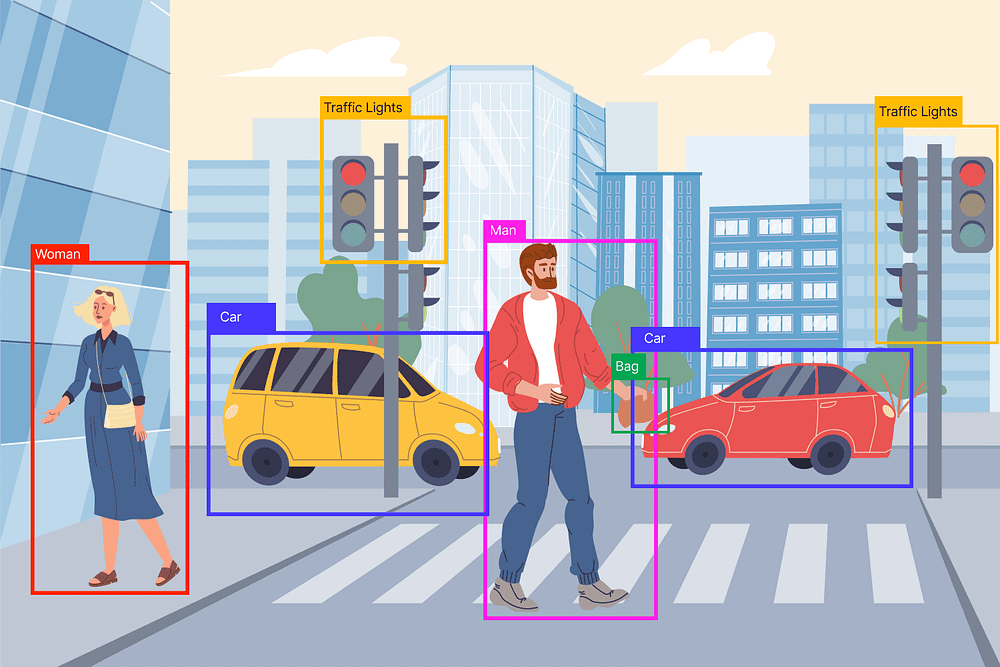


# 3. Building Object Detection Pipeline using 🤗 Transformers

We will work with the detr-resnet-50 model from Meta, which is a well-regarded choice for object detection tasks. It's part of a wide range of models available in the AI ecosystem, accessible through platforms like the Hugging Face Hub.
You can select models based on metrics such as the number of downloads, likes, or evaluation metrics provided on model cards. For this lab, we'll be using detr-resnet50 it to conduct our experiments and explore its functionalities. We will start with defining the object detection pipeline and import the model:

In [5]:
from transformers import pipeline

od_pipe = pipeline("object-detection", model="facebook/detr-resnet-50")     

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

Next, we will load and resize the image

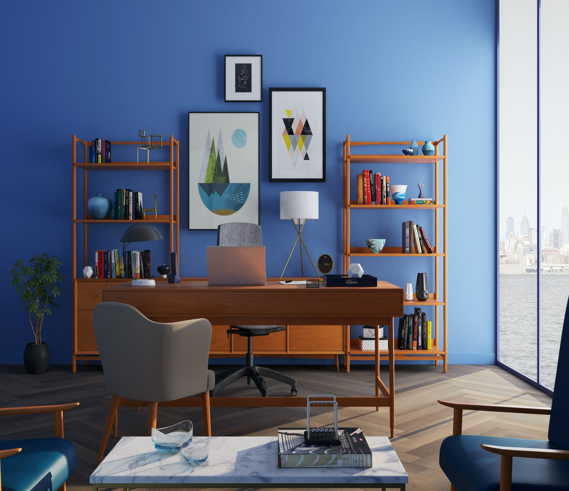

In [6]:
from PIL import Image
raw_image = Image.open('/kaggle/input/object-detection-image/objects-in-english.jpg')
raw_image.resize((569, 491))

Next, we apply the object detection pipeline on the image and we will pass the pipeline output and the raw image to the render_results_in_image and it will return the image with the labels.

In [7]:
import io

pipeline_output = od_pipe(raw_image)
processed_image = render_results_in_image(
    raw_image, 
    pipeline_output)

processed_image

We can see that most of the objects were detected in the image. However, some of the objects are not detected, however, most of them are detected, which is enough for our use case.

# 4. Building the Application with Gradio

The next step will be that we will build Gradio pipeline for the application interface. We will start by defining the get_pipeline_prediction which will take the image and return the processed image.

In [8]:
import os
import gradio as gr

def get_pipeline_prediction(pil_image):
    
    pipeline_output = od_pipe(pil_image)
    
    processed_image = render_results_in_image(pil_image,
                                            pipeline_output)
    return processed_image

Next, we will define a Gradio interface named demo, which is used to create a simple web-based application for demonstrating the object detection pipeline.

The interface is constructed using the gr.Interface class, where the fn parameter specifies the function get_pipeline_prediction to be called when an input is provided.

The inputs parameter is configured to accept an image file with the label "Input image" and a data type of pil (Python Imaging Library), allowing users to upload or draw an image directly in the interface.

The outputs parameter specifies that the output will be an image labeled "Output image with predicted instances" and also uses the pil data type, ensuring that the function's output is visualized with annotations.

This setup facilitates user interaction by taking an image as input, processing it with the specified function, and displaying the processed image with detected objects highlighted.

In [9]:
demo = gr.Interface(
  fn=get_pipeline_prediction,
  inputs=gr.Image(label="Input image", 
                  type="pil"),
  outputs=gr.Image(label="Output image with predicted instances",
                   type="pil")
)

Next, we will launch the previously defined Gradio interface, demoon a specific port and with sharing enabled. Below is a detailed explanation of each part of this code:

In [10]:
# import os

# # Use a default port if 'PORT1' is not found in the environment variables
# server_port = int(os.environ.get('PORT1', 7860))

# demo.launch(share=True, server_port=server_port)


Here is what the interface looks like, you can submit the image and the processed image will be printed. Finally, it is important to close the demo after finishing using it.

# 5. Creating an AI-powered Assistant
The final step is to build a voice-assisted assistant that will communicate the results with visually impaired people. However, lets first have a look at the pipeline output:

In [11]:
pipeline_output

[{'score': 0.8827278017997742,
  'label': 'book',
  'box': {'xmin': 1638, 'ymin': 619, 'xmax': 1666, 'ymax': 734}},
 {'score': 0.8455535173416138,
  'label': 'book',
  'box': {'xmin': 1690, 'ymin': 625, 'xmax': 1715, 'ymax': 735}},
 {'score': 0.8416430950164795,
  'label': 'chair',
  'box': {'xmin': 918, 'ymin': 872, 'xmax': 1368, 'ymax': 1435}},
 {'score': 0.8697077631950378,
  'label': 'book',
  'box': {'xmin': 564, 'ymin': 901, 'xmax': 596, 'ymax': 1005}},
 {'score': 0.8575518131256104,
  'label': 'book',
  'box': {'xmin': 459, 'ymin': 501, 'xmax': 491, 'ymax': 591}},
 {'score': 0.8453609347343445,
  'label': 'book',
  'box': {'xmin': 425, 'ymin': 498, 'xmax': 455, 'ymax': 593}},
 {'score': 0.8656238317489624,
  'label': 'book',
  'box': {'xmin': 1823, 'ymin': 1133, 'xmax': 1870, 'ymax': 1268}},
 {'score': 0.8548740148544312,
  'label': 'book',
  'box': {'xmin': 431, 'ymin': 904, 'xmax': 461, 'ymax': 1003}},
 {'score': 0.5547834634780884,
  'label': 'bench',
  'box': {'xmin': 1959, 

We can see that the output is the label of the detected objects, the score, and the dimension of the detected box. Next, we will pass this output to the summarize function which will take the pipeline output as input and will return a summarized text of the predicted labels.

In [12]:
text = summarize_predictions_natural_language(pipeline_output)
text

'In this image, there are fifty-seven books five chairs two benchs one remote one vase five bowls one couch one potted plant and one dining table.'

The next step is to define a **text-to-speech** pipeline using the **vits-ljs** model from **kakao-enterprise** and then we will pass the summarized text to this pipeline:

In [13]:
# tts_pipe = pipe = pipeline("text-to-speech", model="kakao-enterprise/vits-ljs")     
# narrated_text = tts_pipe(text)

The final step is to listen to this text with the **IPythonAudio** function

In [14]:
# from IPython.display import Audio as IPythonAudio
# IPythonAudio(narrated_text["audio"][0],
#              rate=narrated_text["sampling_rate"])